# Setup

In [1]:
# Mount drive
import os
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
root = '/gdrive/My Drive/CS454 AI-Based SE/Code'

In [3]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST, ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab.patches import cv2_imshow

model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [4]:
# Set hyperparameters
from easydict import EasyDict as edict

torch.manual_seed(470)
torch.cuda.manual_seed(470)

args = edict()
args.gpu = True                      # whether or not to use gpu. 

# data options
args.dataroot = 'dataset/mnist'    # where MNIST images exist.
args.batch_size = 128                # number of mini-batch size.

# training options
args.lr = 0.01                        # learning rate.
args.epoch = 15                     # training epoch.

In [5]:
result_dir = Path(root) / 'results_mnist'
result_dir.mkdir(parents=True, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu' # move the input and model to GPU for speed if available
model = model.to(device)

In [6]:
# sample execution (requires torchvision)
import torchvision
train_transform = transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])

test_transform = transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])

train_dataset = MNIST(args.dataroot, download=True, train=True, transform=train_transform)
test_dataset = MNIST(args.dataroot, download=True, train=False, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False)

Extracting dataset/mnist/MNIST/raw/train-images-idx3-ubyte.gz to dataset/mnist/MNIST/raw


Extracting dataset/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/mnist/MNIST/raw




Extracting dataset/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/mnist/MNIST/raw


Extracting dataset/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Training the Model
Skip this part since the weight is already stored

In [7]:
def test_model(model, optimizer):
    global_step = 0
    best_accuracy = 0.

    for epoch in range(args.epoch):
        # Here starts the train loop.
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):

            global_step += 1

            #  Send `x` and `y` to either cpu or gpu using `device` variable. 
            x = x.to(device)
            y = y.to(device)
            
            # Feed `x` into the network, get an output, and keep it in a variable called `logit`. 
            logit = model(x)

            # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
            accuracy = (logit.argmax(1) == y).float().mean()

            # print(logit)
            # print(y)
            # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
            loss = nn.CrossEntropyLoss()(logit, y)

            # flush out the previously computed gradient.
            optimizer.zero_grad()

            # backward the computed loss. 
            loss.backward()

            # update the network weights. 
            optimizer.step()

            if global_step % args.ckpt_iter == 0: 
                # Save network weights in the directory specified by `ckpt_dir` directory. 
                torch.save(model.state_dict(), f'{result_dir}/{global_step}.pt')

        # Here starts the test loop.
        model.eval()
        with torch.no_grad():
            test_loss = 0.
            test_accuracy = 0.
            test_num_data = 0.
            for batch_idx, (x, y) in enumerate(test_dataloader):
                # Send `x` and `y` to either cpu or gpu using `device` variable..
                x = x.to(device)
                y = y.to(device)

                # Feed `x` into the network, get an output, and keep it in a variable called `logit`.
                logit = model(x)

                # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
                loss = nn.CrossEntropyLoss()(logit, y)

                # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
                accuracy = (logit.argmax(dim=1) == y).float().mean()

                test_loss += loss.item()*x.shape[0]
                test_accuracy += accuracy.item()*x.shape[0]
                test_num_data += x.shape[0]

            test_loss /= test_num_data
            test_accuracy /= test_num_data

            # Just for checking progress
            print(f'Test result of epoch {epoch}/{args.epoch} || loss : {test_loss:.3f} acc : {test_accuracy:.3f} ')

            # Whenever `test_accuracy` is greater than `best_accuracy`, save network weights with the filename 'best.pt' in the directory specified by `ckpt_dir`.
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                torch.save(model.state_dict(), f'{result_dir}/best.pt')
    
        # scheduler.step()
    return best_accuracy

In [ ]:
#Updating the second classifier
model.features[0] = nn.Conv2d(1, 64, (4, 4), stride=(2,2), padding=(2, 2))
model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
model.classifier[6] = nn.Linear(1024,10)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

In [ ]:
# Start training (Result for pretrained model)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,80], gamma=0.5)

# Call the train & test function.
t1 = time.time()
model.cuda()
accuracy = test_model(model, optimizer)
t = time.time()-t1
print(f'Best test accuracy of AlexNet : {accuracy:.3f} took {t:.3f} secs')

Test result of epoch 0/15 || loss : 0.039 acc : 0.988 
Test result of epoch 1/15 || loss : 0.040 acc : 0.988 
Test result of epoch 2/15 || loss : 0.042 acc : 0.986 


KeyboardInterrupt: ignored

# Inference
Test if the model works well by loading the weight into the pretrained model

In [8]:
# Load the trained model using CIFAR
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet')
#Updating the second classifier
model.features[0] = nn.Conv2d(1, 64, (4, 4), stride=(2,2), padding=(2, 2))
model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
model.classifier[6] = nn.Linear(1024,10)
model.load_state_dict(torch.load(root+'/results_mnist/best.pt'))
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

Import the test dataset and get a random sample

tensor([0])
tensor(0)
tensor([7])
tensor(7)
tensor([4])
tensor(4)
tensor([0])
tensor(0)
tensor([1])
tensor(1)
tensor([3])
tensor(3)
tensor([1])
tensor(1)
tensor([3])
tensor(3)
tensor([4])
tensor(4)
tensor([7])
tensor(7)
tensor([2])
tensor(2)
tensor([7])
tensor(7)
tensor([1])
tensor(1)
tensor([2])
tensor(2)
tensor([1])
tensor(1)
tensor([1])
tensor(1)
tensor([7])
tensor(7)
tensor([4])
tensor(4)
tensor([2])
tensor(2)
tensor([3])
tensor(3)
tensor([5])
tensor(5)
tensor([1])
tensor(1)
tensor([2])
tensor(2)
tensor([4])
tensor(4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4])
tensor(4)
128
tensor([0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4,
        4])


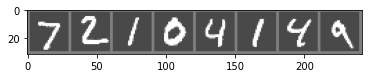

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
for i in range (25):
  res = model(images[i+25].view(1, 1, 28, 28))
  print(res.argmax(1))
  print(labels[i+25])

print(len(images))
print(labels[25:50])

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels

# DeepSearch


## DeepSearch's github code
(insert code link)

In [ ]:
import numpy as np 
from itertools import product
# import heapq
# from pickle import load
class Image:
    def __init__(self, base, model, true_class, epsilon, group_size=1, group_axes=[1], u_bound=1,l_bound=0,start_mode=-1, logits=False, x_ent=False,verbose=True):
        preprocess=lambda x:x.reshape(base.shape)
        self.orig_shape=base.shape
        self.calls=0
        self.group_axes=group_axes
        self.verbose=verbose
        self.group_size=group_size
        def predict(x):
            self.calls+=1
            return model(preprocess(x).unsqueeze(0).unsqueeze(1)).reshape(-1)
        self.predict=predict
        self.true_class=true_class
        self.upper=torch.clip(base.reshape(-1)+epsilon,l_bound,u_bound)
        self.lower=torch.clip(base.reshape(-1)-epsilon,l_bound,u_bound)
        self.status=torch.ones_like(self.lower)
        if start_mode>0:
            self.image=self.upper.clone()
        elif start_mode<0:
            self.image=self.lower.clone()
            self.status=self.status*-1
        else:
            self.image=base.reshape(-1)
            self.status=self.status*0
        self.gains=torch.zeros_like(self.lower)
        self.gains_to=torch.zeros_like(self.lower)
        def loss(image):
            res=self.predict(image)
            if torch.argmax(res)!=true_class:
                return -50000
            if logits:
                if x_ent:
                    return res[true_class]-torch.log(torch.sum(torch.exp(res)))
                else:
                    rest=torch.ones_like(res)
                    rest[true_class]=0
                    return res.true_class-torch.max(res[rest>0])
            else:
                if x_ent:
                    return torch.log(res[true_class])
                else:
                    rest=torch.ones_like(res)
                    rest[true_class]=0
                    return torch.log(res[true_class])-torch.log(torch.max(res[rest>0]))
        self.loss_fn=loss
        self.loss=loss(self.image)
        self.stale=torch.zeros_like(self.gains)
        self.rmap=preprocess(torch.arange(len(self.image)))
    def get_indices(self,source):
        j=[]
        for i in reversed(self.orig_shape):
            j.append(source % i)
            source=source//i
        j=list(reversed(j))
        print(j)
        print(self.group_axes)
        for i in self.group_axes:
            j[i]=j[i]-(j[i] % self.group_size)
        indices=[]
        for i in range(len(self.orig_shape)):
            if i in self.group_axes:
                indices.append(list(range(j[i],j[i]+self.group_size)))
            else:
                indices.append([j[i]])
        ret=[]
        # print(list(product(*indices)))
        for k in product(*indices):
            # print(type(self.rmap[k].item()))
            ret.append(self.rmap[k].item())
        # print(ret)
        return ret
    def get_pivots(self,direction):
        indices=[]
        ret=[]
        for i in range(len(self.orig_shape)):
            indices.append(list(range(0,self.orig_shape[i],self.group_size if i in self.group_axes else 1)))
        for k in product(*indices):
            if direction==0 or self.status[self.rmap[k]]==direction:
                ret.append(self.rmap[k])
        return ret
    def gain(self, index, force=False, no_update=False, direction=0):
        if direction==0:
            if self.status[index]>0:
                direction=-1
            else:
                direction=1
        if self.gains_to[index]==direction and (not force):
            return self.gains[index]
        pert=self.image.clone()
        # print(self.get_indices(index))
        pert[self.get_indices(index)]=self.lower[self.get_indices(index)] if direction<0 else self.upper[self.get_indices(index)]
        res=self.loss_fn(pert)
        self.gains_to[index]=direction
        self.gains[index]=res-self.loss
        self.stale[index]=0
        return res-self.loss
    
    def push(self, index, loss_diff, direction=0):
        if direction==0:
            if self.status[index]>0:
                direction=-1
            else:
                direction=1
        self.image[self.get_indices(index)]=self.lower[self.get_indices(index)] if direction<0 else self.upper[self.get_indices(index)]
        self.status[self.get_indices(index)]=direction
        self.stale+=1
        self.loss+=loss_diff
        if self.verbose:
            print("Pushing group of",self.group_size,"beginning at",index,"to",["lower bound,","","upper bound,"][direction+1],"Current loss is",self.loss,"and",self.calls,"calls have been made to the model.")
    def reset(self):
        self.stale=self.stale*0
        self.gains_to=self.gains_to*0
        self.loss=self.loss_fn(self.image)
        if self.verbose:
            print("Purging gains cache")
    
    def sample_indices(self, count, direction=0):
        lst=self.get_pivots(direction)
        try:
            return np.random.choice(lst,count,False)
        except ValueError:
            return lst

def DeepSearch(image,model,true_class,epsilon,max_calls):
    target=Image(image,model,true_class,epsilon,group_size=16,x_ent=True)
    print("Initial loss is",target.loss)
    while(target.loss>-10000 and target.calls<max_calls):
        selected=[]
        print(len(target.get_pivots(0)))
        pivots = 0
        for x in target.get_pivots(0):
            print(pivots)
            pivots += 1
            if target.gain(x,True)<0:
                selected.append(x)
        for x in selected:
            target.push(x,0)
        target.loss=target.loss_fn(target.image)
        if target.group_size>1:
            target.group_size=target.group_size//2
        target.reset()
    if target.loss>-10000:
        return False,image,target.calls
    return True,target.image,target.calls


def DeepSearchBatched(image,model,true_class,epsilon,max_calls,batch_size=4,randomize=True,x_ent=False,gr_init=4):
    target=Image(image,model,true_class,epsilon,group_size=gr_init,x_ent=x_ent)
    print("Initial loss is",target.loss)
    while(target.loss>-10000 and target.calls<max_calls):
        selected=[]
        cur_batch=0
        all_pivots=target.get_pivots(0)
        if randomize:
            np.random.shuffle(all_pivots)
        for x in all_pivots:
            cur_batch+=1
            if target.gain(x,True)<0:
                selected.append(x)
            if cur_batch==batch_size:
                for x in selected:
                    target.push(x,0)
                target.loss=target.loss_fn(target.image)
                if target.loss<-10000:
                    return True,target.image,target.calls
                if target.calls>max_calls:
                    return False,image,target.calls
                cur_batch=0
                selected=[]
        for x in selected:
            target.push(x,0)
        target.loss=target.loss_fn(target.image)
        if target.group_size>1:
            target.group_size=target.group_size//2
        target.reset()
    if target.loss>-10000:
        return False,image,target.calls
    return True,target.image,target.calls

## My Deep Search
This algorithm is created based on the pseudocode on the DeepSearch paper

In [12]:
def ApproxMax(x, f, interval):
  out = torch.zeros(x.size())
  for i in range(len(interval)):
    upper_x = out.clone()
    upper_x[i] = interval[i][1]
    lower_x = out.clone()
    lower_x[i] = interval[i][0]
    if f(upper_x) > f(lower_x):
      out = upper_x
    else:
      out = lower_x
  return out

def ApproxMin(x, f, model, interval, query, correct_class):
  x_size = x.size()
  x = x.view(-1)
  out = x
  for i in range(len(interval)):
    before, query = f(out.view(x_size), query)
    upper_x = out.clone()
    upper_x[i] = interval[i][1]
    lower_x = out.clone()
    lower_x[i] = interval[i][0]
    upper_x_f, query = f(upper_x.view(x_size), query)
    lower_x_f, query = f(lower_x.view(x_size), query)
    if upper_x_f > lower_x_f:
      new = lower_x
      after = lower_x_f
    else:
      new = upper_x
      after = upper_x_f
    if after < before:
      print(after)
      out = new
    if after < 0 and multiclass_classify(model, x, query) == correct_class:
      return out.view(x_size), query
  return out.view(x_size), query

# Assumption: if f(x) > 0, x is classified as class[0] 
def binary_classify(f, x):
  classname = [0, 1]
  if f(x) > 0:
    return classname[0]
  else:
    return classname[1]

def DS_Binary(x, x_init, f, d):
  # Construct the interval
  interval = []
  for i in range(len(x)):
    interval.append([x[i]-d, x[i]+d])
  # Initialize variable
  x_0 = x_init
  k = 0
  if f(x_0) > 0:
    x_k = ApproxMin(x, f, interval)
    k = k + 1
    while binary_classify(f, x) == binary_classify(f, x_k):
      x_k = ApproxMin(x_k, f, interval)
      k = k + 1
  else:
    x_k = ApproxMax(x, f, interval)
    k = k + 1
    while binary_classify(f, x) == binary_classify(f, x_k):
      x_k = ApproxMax(x_k, f, interval)
      k = k + 1
  return x_k

In [13]:
# Calculate sub classification function 
def g_ij(f, x, i, j, query):
  #Depends on what f is: a matrix or an array of function
  # print(f(x)[0][i])
  x = x.view(1, 1, 28, 28)
  query += 1
  f_x = f(x)
  return f_x[0][i] - f_x[0][j], query

# Binary classifier of g_ij
def classify_g_ij(f, x, classes, i, j, query):
  g, query = g_ij(f, x, i, j, query)
  if g > 0:
    return classes[i], query
  else:
    return classes[j], query

def multiclass_classify(f, x, query):
  query += 1
  x = x.view(1, 1, 28, 28)
  return f(x).argmax(1)

def DS_Multiclass(x, model, d, classes, max_loop=25):
  # Construct the interval
  x_size = x.size()
  x = x.view(-1)
  interval = []
  for i in range(len(x)):
    interval.append([x[i]-d, x[i]+d])
  # Initialize variable
  query = 0
  correct_class= multiclass_classify(model, x.view(x_size), query)
  query += 1
  i = classes.index(correct_class)
  x_k = x
  k = 0
  prev_out = model(x_k.view(1, 1, 28, 28)).max()
  while multiclass_classify(model, x_k, query) == correct_class and k < max_loop:
    query += 1 # For the multiclass_classify
    min_g_ij = np.Inf
    min_j = 0
    for j in range(len(classes)):
      if j == i:
        continue
      curr_g_ij, query = g_ij(model, x_k, i, j, query)
      if curr_g_ij < min_g_ij:
        min_j = j
        min_g_ij = curr_g_ij
    g_rj = lambda curr_x, qry: g_ij(model, curr_x, i, min_j, qry) # Alternative in case the above is wrong
    new_xk, query = ApproxMin(x_k, g_rj, model, interval, query, correct_class) #The g_ij part is till wrong
    k = k + 1
    output = model(new_xk.view(1, 1, 28, 28))
    query += 1
    if output.max() < prev_out:
      x_k = new_xk
      prev_out = output.max()
    if output.argmax(1) != correct_class:
      return (x_k, True, query)
  if k == max_loop:
    return (x_k, False, query)
  else:
    return (x_k, True, query)

## Apply the DeepSearch

**Ideas for comparisons and visualization**

Comparison vs:
*   Queries (amount of calls to model())
*   Time
*   Chebyshev distance

Visualization: Compare different epsilon against: 
*   Time
*   chebyshev distance




In [ ]:
import time
import json
results = []
checkpoint = None
for i in range(11):
  if checkpoint is not None:
    if i < check_point:
      continue
  print("Image {}/50".format(i+19))
  sample_test = images[i+18].view(28, 28)
  entry_result = {}
  start = time.process_time()
  query = 0
  output = model(sample_test.unsqueeze(0).unsqueeze(1))
  true_class = output.argmax(1)
  (image_res, res, query) = DS_Multiclass(sample_test, model, 16/255, list(range(10)))
  entry_result['index'] = i+18
  entry_result['time'] = time.process_time() - start
  entry_result['result'] = res
  entry_result['query'] = query
  entry_result['true_class'] = true_class.item()
  results.append(entry_result)
  with open(root+'/deepsearch_result1.txt', 'w') as writefile:
    writefile.write(json.dumps(results))

Image 1/50
Image 2/50
Image 3/50
Image 4/50
Image 5/50
Image 6/50
Image 7/50
Image 8/50
Image 9/50
Image 10/50
Image 11/50
Image 12/50
Image 13/50
Image 14/50
Image 15/50
Image 16/50
Image 17/50
Image 18/50
Image 19/50


TypeError: ignored

In [ ]:
import statistics
import json

success = 0
total = 0
queries = []
time_taken = []
success_per_number = {}
fail_per_number = {}
for i in range(10):
  success_per_number[i] = 0
  fail_per_number[i] = 0
for i in range(len(results)):
  result = results[i]
  if result['result']:
    success += 1
    success_per_number[result['true_class']] += 1
  else:
    fail_per_number[result['true_class']] += 1
  total += 1
  queries.append(result['query'])
  time_taken.append(result['time'])
  # results[i]['true_class'] = result['true_class'].item()


print("Number of successful attack: {}/{}".format(success, total))
print("Average queries: {}".format(round(statistics.mean(queries))))
print("Average time-taken: {}".format(round(statistics.mean(time_taken))))
print("Mdian time-taken: {}".format(statistics.median(time_taken)))
print("Median queries: {}".format(statistics.median(queries)))
print("Success per number: {}".format(success_per_number))
print("Fail per number: {}".format(fail_per_number))
# print(result)
with open(root+'/deepsearch_result.txt', 'w') as writefile:
    writefile.write(json.dumps(results))

Number of successful attack: 27/43
Average queries: 29208
Average time-taken: 500
Mdian time-taken: 40.914866840000286
Median queries: 2425
Success per number: {0: 2, 1: 4, 2: 0, 3: 2, 4: 5, 5: 1, 6: 2, 7: 0, 8: 7, 9: 4}
Fail per number: {0: 0, 1: 6, 2: 2, 3: 3, 4: 4, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0}


tensor(0.7242, grad_fn=<SubBackward0>)
tensor(0.7154, grad_fn=<SubBackward0>)
tensor(0.7057, grad_fn=<SubBackward0>)
tensor(0.6904, grad_fn=<SubBackward0>)
tensor(0.6842, grad_fn=<SubBackward0>)
tensor(0.6680, grad_fn=<SubBackward0>)
tensor(0.6599, grad_fn=<SubBackward0>)
tensor(0.6499, grad_fn=<SubBackward0>)
tensor(0.6436, grad_fn=<SubBackward0>)
tensor(0.6245, grad_fn=<SubBackward0>)
tensor(0.6182, grad_fn=<SubBackward0>)
tensor(0.6002, grad_fn=<SubBackward0>)
tensor(0.5947, grad_fn=<SubBackward0>)
tensor(0.5817, grad_fn=<SubBackward0>)
tensor(0.5751, grad_fn=<SubBackward0>)
tensor(0.5659, grad_fn=<SubBackward0>)
tensor(0.5629, grad_fn=<SubBackward0>)
tensor(0.5624, grad_fn=<SubBackward0>)
tensor(0.5620, grad_fn=<SubBackward0>)
tensor(0.5599, grad_fn=<SubBackward0>)
tensor(0.5565, grad_fn=<SubBackward0>)
tensor(0.5473, grad_fn=<SubBackward0>)
tensor(0.5395, grad_fn=<SubBackward0>)
tensor(0.5270, grad_fn=<SubBackward0>)
tensor(0.5193, grad_fn=<SubBackward0>)
tensor(0.5056, grad_fn=<S

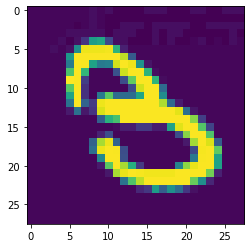

In [20]:
sample_test = images[18].view(28, 28)
(image_res, res, query) = DS_Multiclass(sample_test, model, 16/255, list(range(10)))
res_output = model(image_res.view(1, 1, 28,28))
# print(loop)
print(res_output.argmax(1))
plt.imshow(image_res.view(28, 28))

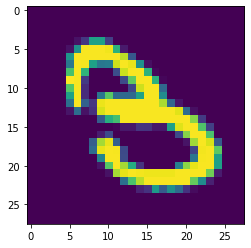

In [30]:
# imshow(image_res.view(1, 28, 28))
plt.imshow(sample_test.view(28, 28))
# plt.imshow(image_res.view(28, 28))

Note: Works especially well with numbers 

*   5 -> 3
*   0 -> 2

